# Project Proposal: Pulsar Classification
**DSCI 100 (007-34) Group Project Proposal**  
Group members:
- Elliot Saha
- Alasdair Buchanan
- Sarah Trevisan
- Minghao Li

## 1. Introduction

### 1.1 Background Information

### 1.2 Research Question

### 1.3 Dataset

## 2. Data analysis

### 2.1 Data Reading

In [1]:
# import tidyverse, repr, and tidymodels
library(tidyverse)
library(repr)
library(tidymodels)
# set random seed
set.seed(1111)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
pulsar_data <- read_csv("data/HTRU_2.csv", col_names=FALSE)
head(pulsar_data)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


As we can see from the dataset, there are 8 distinct variables and 1 target label with 17,898 observations in total.

### 2.2 Data Wrangling

We noticed the dataframe does not have proper column names and the type of the label column is incorrect. Therefore, we performed the following operations to clean the data.

In [3]:
# rename the columns according to data/Readme.txt
pulsar_data <- pulsar_data |>
    rename(profile_mean = X1,
          profile_sd = X2,
          profile_kurtosis = X3,
          profile_skewness = X4,
          DM_SNR_mean = X5,
          DM_SNR_sd = X6,
          DM_SNR_kurtosis = X7,
          DM_SNR_skewness = X8,
          pulsar_star = X9) |> 
    drop_na() |>
    # mark the label column as a categorical variable
    mutate(pulsar_star = as_factor(pulsar_star)) |>
    # pulsar_star refers to if the row is a pulsar star or not
    mutate(pulsar_star = fct_recode(pulsar_star, "true" = "1", "false" = "0"))

head(pulsar_data)

profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,false
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,false
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,false
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,false
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,false
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,false


Here, we divide the entire data set to a training part and a test part. The training set is 70% of the entire dataset, while testing set takes the other 30%.

In [4]:
pulsar_split <- initial_split(pulsar_data, prop = 0.7, strata = pulsar_star)  
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)
head(pulsar_train)
head(pulsar_test)

profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
102.5078,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,false
136.7500,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,false
119.4844,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,false
130.3828,39.84406,-0.15832276,0.3895404,1.2207358,14.378941,13.539456,198.23646,false
107.2500,52.62708,0.45268802,0.1703474,2.3319398,14.486853,9.001004,107.97251,false
107.2578,39.49649,0.46588196,1.1628771,4.0794314,24.980418,7.397080,57.78474,false


profile_mean,profile_sd,profile_kurtosis,profile_skewness,DM_SNR_mean,DM_SNR_sd,DM_SNR_kurtosis,DM_SNR_skewness,pulsar_star
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.69964840,3.199833,19.11043,7.975532,74.24222,false
103.01562,39.34165,0.32332837,1.05116443,3.121237,21.74467,7.735822,63.17191,false
88.72656,40.67223,0.60086608,1.12349169,1.178930,11.46872,14.269573,252.56731,false
93.57031,46.69811,0.53190485,0.41672112,1.636288,14.54507,10.621748,131.39400,false
138.17969,51.52448,-0.03185233,0.04679717,6.330268,31.57635,5.155940,26.14331,false
100.85156,51.74352,0.39383679,-0.01124074,2.841137,21.63578,8.302242,71.58437,false


### 2.3 Data Summary

In order to get more insights on the datasets, here, we first analyze the number of observations in each class.

In [5]:
num_observations <- pulsar_train |>
    group_by(pulsar_star) |>
    summarize(num = n())
num_observations

pulsar_star,num
<fct>,<int>
false,11400
true,1128


Therefore, the category `false` has 11400 observations, while category `true` only has 1128 observations. In this case, when we train the model, we need to be aware of the categorical imbalance in the dataset. We will resample the training set before we feed the data to the model.

### 2.4 Visualization


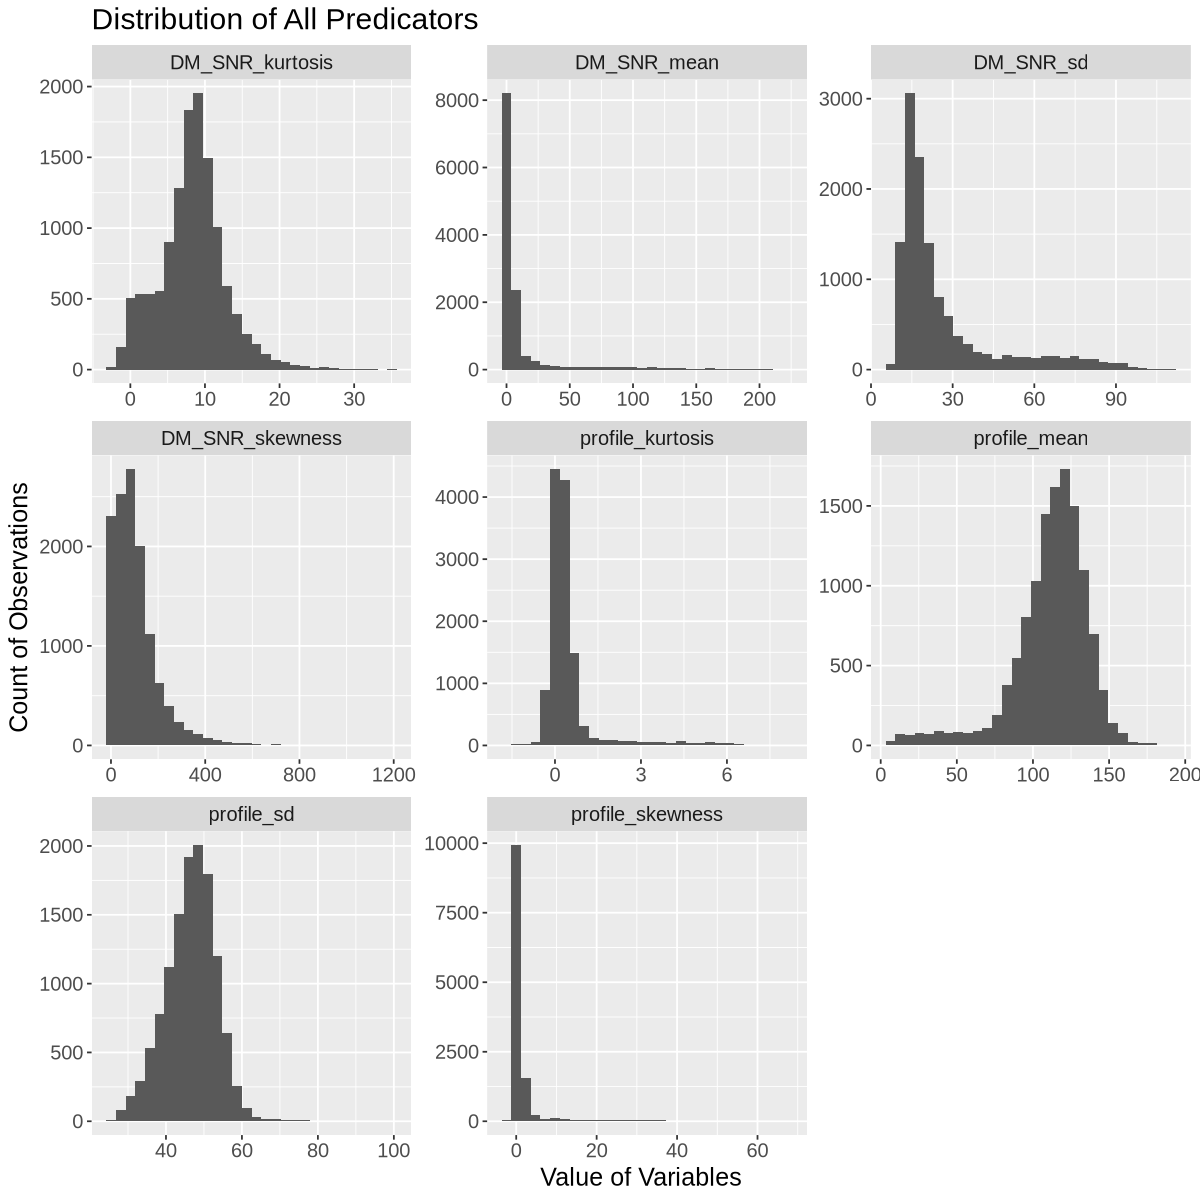

In [32]:
options(repr.plot.width = 10, repr.plot.height=10)
distribution_plot <- pulsar_train |> 
    pivot_longer(profile_mean:DM_SNR_skewness, values_to="value", names_to="variable") |>
    ggplot(aes(x=value)) +
    geom_histogram(bins=30) +
    facet_wrap(vars(variable), scales = "free") +
    theme(text = element_text(size=15)) +
    labs(x = "Value of Variables", y = "Count of Observations") +
    ggtitle("Distribution of All Predicators")
distribution_plot

We visulize the distribution of all 8 predictor candicates. It is noticed that all these predictors are distributed in different shapes. Therefore, before we feed the data to model, we need to standarize all of them to get a better model performance.

## 3. Methods

## 4. Expected outcomes and significance